In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score
import xgboost as xgb
from xgboost import plot_importance, to_graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import graphviz

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

%matplotlib inline

In [2]:
def proportion(df,column,plot=False):
    t=df[column].count()
    c=df[column].sum()
    print(f'Total rows: {t}, with flag: {c}, proportion: {c/t}')
    if plot:
        sns.countplot(x=column, data=df)

In [3]:
def plot_roc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (area = %0.6f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def plot_pr(recall,precision,average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: {0:0.6f}'.format(average_precision))
    plt.show()


In [5]:
def plot_learning_curve(results,epochs):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='logloss-Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='logloss-Test')
    ax.plot(x_axis, results['validation_0']['auc'], label='auc-Train')
    ax.plot(x_axis, results['validation_1']['auc'], label='auc-Test')
    ax.legend()
    plt.ylabel('Log Loss/AUC')
    plt.title('XGBoost Log Loss and AUC evolution')
    plt.show()


In [6]:
def run_xgboost_and_calculate_auc(df,
                                  target='target',
                                  drop='variable_to_find_and_exclude',
                                  w=1,
                                  plot_learning=False,
                                  plot_variables=False,
                                  plot_ROC_PR=False,
                                  plot_confusion=False,
                                  plot_graph_tree=False,
                                  learning_rate=0.05,
                                  max_depth=10,
                                  esr=10,
                                  CV=True,
                                  title='',
                                  plot_all=False,
                                  ensembler=False,
                                  test_size=.2):
    '''
    Generic function to run xgboost to test the added changes and plot roc, learning and others and save the model.
    '''
    # features
    X = df.drop(target, axis=1)
    X = pd.get_dummies(X)
    
    # targets
    Y = df[target]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=test_size,
                                                        random_state=12345,
                                                        stratify=Y)

    print(f'variables: {len(list(X))}, rows:{len(X)}, flags:{sum(list(df[target]))}')
    
        
    clf = xgb.XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=4,
        gamma=0.6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=5e-05,
        objective='binary:logistic',
        nthread=20,
        scale_pos_weight=w,
        seed=92,
        use_label_encoder=False
    )

    eval_set = [(X_train, Y_train), (X_test, Y_test)]

    if plot_all:
        plot_learning=True
        plot_variables=True
        plot_ROC_PR=True
        plot_confusion=True
        plot_graph_tree=True
        
    if CV:
        X = pd.concat([X_train,X_test])
        y = pd.concat([Y_train,Y_test])
        xgb_param = clf.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, y.values)
        cvresult = xgb.cv(xgb_param,
                          xgtrain,
                          num_boost_round=clf.get_params()['n_estimators'],
                          nfold=5,
                          metrics='auc',
                          early_stopping_rounds=esr)
        print(cvresult.tail(1))
        clf.set_params(n_estimators=cvresult.shape[0])

    clf.fit(X_train,
            Y_train,
            early_stopping_rounds=25,
            eval_metric=['auc','error','logloss'],
            eval_set=eval_set,
            verbose=False)

    Y_pred = clf.predict_proba(X_test)
    y_true = np.array(Y_test)
    y_scores = Y_pred[:, 1]

    fpr, tpr, _ = roc_curve(Y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    average_precision = average_precision_score(Y_test, y_scores)
    precision, recall, _ = precision_recall_curve(Y_test, y_scores)
    
    if plot_ROC_PR:
        plot_roc(fpr, tpr, roc_auc)
        plot_pr(recall,precision,average_precision)
    else:
        print('Area under ROC: %0.6f' % roc_auc)

    if plot_graph_tree:
        xgb.plot_tree(clf, rankdir='LR')
        fig = plt.gcf()
        fig.set_size_inches(150, 100)

    if plot_learning:
        results = clf.evals_result()
        epochs = len(results['validation_0']['error'])

    if plot_variables:
        xgb.plot_importance(clf,max_num_features=20,importance_type='gain',xlabel='gain')

    if plot_confusion:
        print('\n', classification_report(y_true, y_scores.round()))

    if title:
        #timestr = time.strftime("%Y%m%d-%H%M%S")
        clf.save_model(title)

    if ensembler:
        return Y_test, y_scores

    print('-------------END EXECUTION-------------')

In [7]:
df_image = pd.read_csv("csv/train_vendor.csv")
df_image['file'] = "dicom/" + df_image.CENTER + '/' + df_image.file
df_image.GROUP = [0 if i == "control" else 1 for i in df_image.GROUP]

In [8]:
df_predict = pd.read_csv("csv/predict_image_vendor.csv").merge(pd.read_csv("csv/predict_density_vendor.csv"))
df_predict = df_image.merge(df_predict)
df_cal = df_predict[df_predict.dataset=="cal"]
df_test = df_predict[df_predict.dataset=="test"]
df_cal.value_counts(["CENTER","GROUP"])

CENTER   GROUP
ncc2020  0        467
         1        155
asan     0        120
         1         66
dtype: int64

### only area (noDL) - model name : xgboost_onlyarea_vendor.json

variables: 4, rows:646, flags:164


/home/jslee/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
25        0.852796       0.008299       0.739888      0.037194
Area under ROC: 0.722899


/home/jslee/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/jslee/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


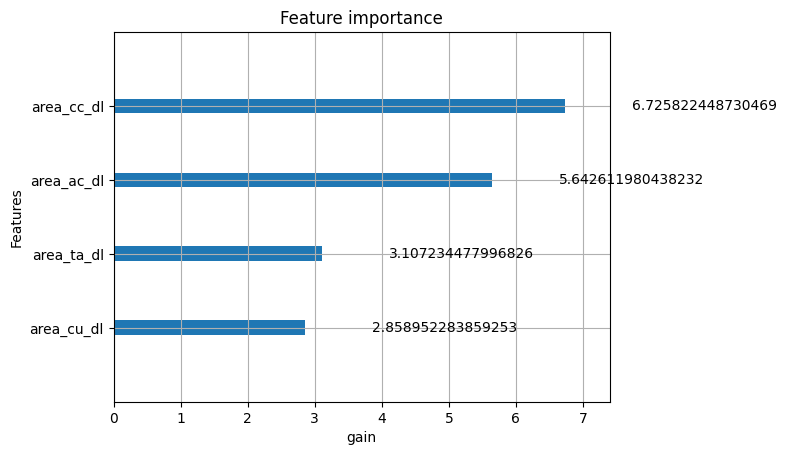

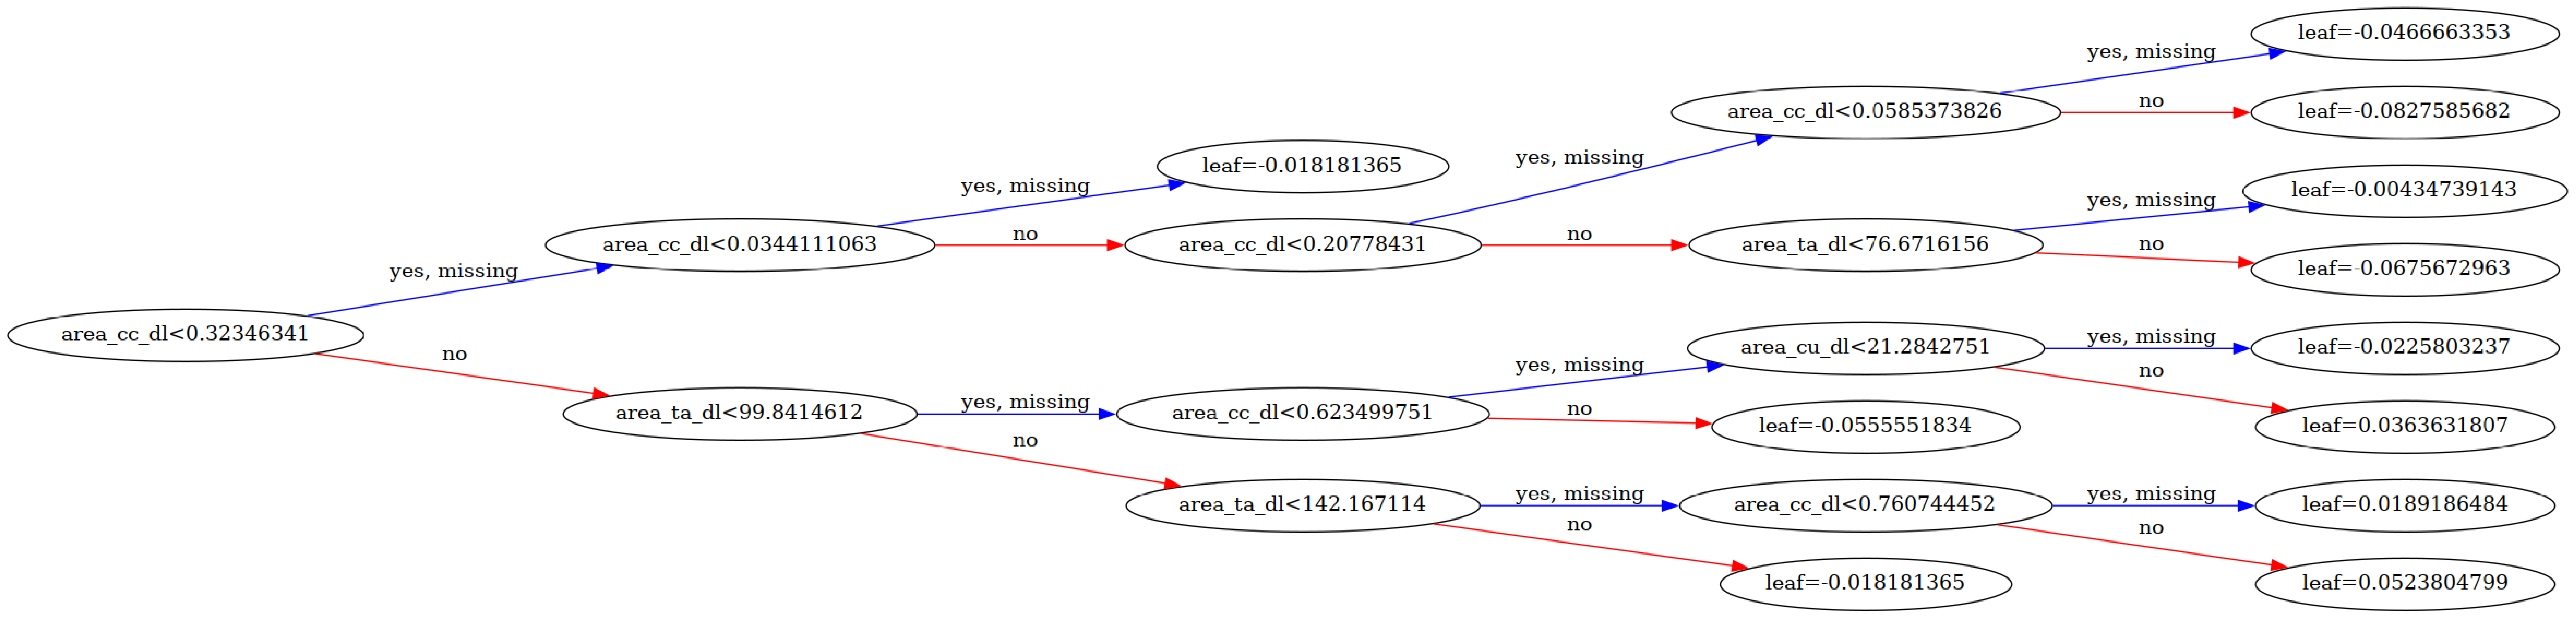

In [37]:
X = df_cal[["file","GROUP",'area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl']]
y = df_cal[['GROUP']]

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=92)
Y_test, y_scores = run_xgboost_and_calculate_auc(X_train.drop("file",axis=1),target='GROUP',plot_all=False,ensembler=True, title="model/xgboost_onlyarea_vendor.json")

model_test = xgb.XGBClassifier()
model_test.load_model("model/xgboost_onlyarea_vendor.json")
xgb.plot_importance(model_test,max_num_features=20,importance_type='gain',xlabel='gain')
xgb.plot_tree(model_test, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


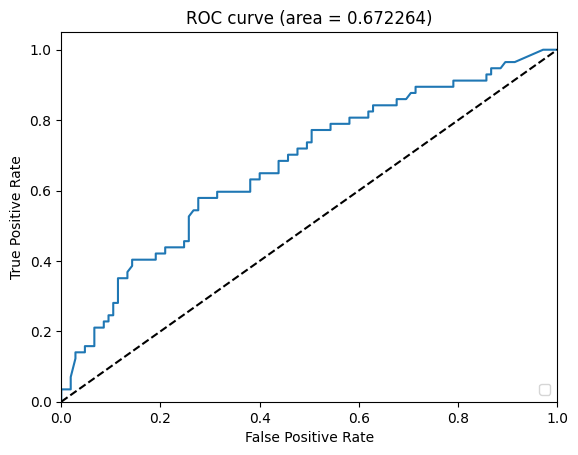

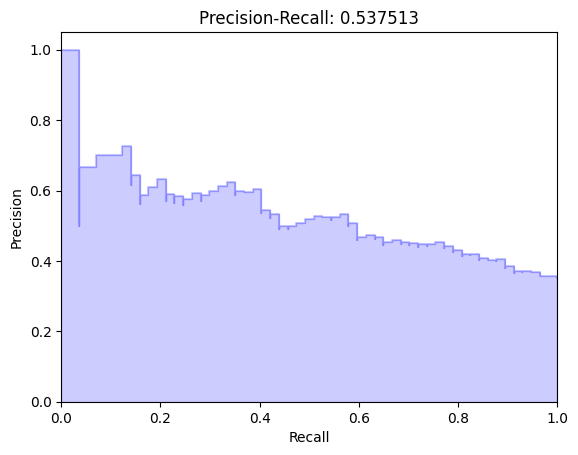


               precision    recall  f1-score   support

           0       0.68      0.92      0.79       105
           1       0.60      0.21      0.31        57

    accuracy                           0.67       162
   macro avg       0.64      0.57      0.55       162
weighted avg       0.65      0.67      0.62       162



In [38]:
y_pred = model_test.predict_proba(X_test.drop(["file","GROUP"], axis=1))
y_true = np.array(y_test)
y_scores = y_pred[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
average_precision = average_precision_score(y_test, y_scores)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall,precision,average_precision)
print('\n', classification_report(y_true, y_scores.round()))
#pd.DataFrame(zip(X_test['file'], y_test.GROUP.tolist(),y_scores),columns=['file','GROUP','scores']).to_csv("xgboost_density.csv",index=False)

In [39]:
y_pred = model_test.predict_proba(df_test[['area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl']])
y_scores = y_pred[:, 1]

In [40]:
import csv

In [41]:
name = 'csv/xgboost_onlyarea.csv'

with open(name, 'w') as result: 
    write = csv.writer(result)
    write.writerow(['file','scores'])

In [42]:
for i in range(len(df_test)):
    file = df_test.file.tolist()[i]
    score = y_scores[i]
    with open(name, 'a') as result: 
        write = csv.writer(result)
        write.writerow([file,score])

In [43]:
model_test = xgb.XGBClassifier()
model_test.load_model("model/xgboost_onlyarea_vendor.json")

In [44]:
df_test["scores"] = model_test.predict_proba(df_test[['area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl']])[:, 1]

/tmp/ipykernel_31521/414848511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["scores"] = model_test.predict_proba(df_test[['area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl']])[:, 1]


In [45]:
df_test.to_csv("csv/test_onlyarea.csv")

In [46]:
df_test

,dataset,dataset_density,dataset_image,file_image,file,CENTER,ID,DATE,SIDE,SIDE_case,...,area_ta_dl,area_cu_dl,area_ac_dl,area_cc_dl,percent_ta_dl,percent_cu_dl,percent_ac_dl,percent_cc_dl,scores,scores_total
1,test,yes,yes,numpy/image_256x256/asan/10822454_RCC_20071228...,dicom/asan/10822454_RCC_20071228.dcm,asan,10822454,20071228.dcm,RCC,NaN,...,88.016064,21.818978,10.545612,0.864130,100.0,24.789768,11.981463,0.981787,0.367334,0.561271
3,test,yes,yes,numpy/image_256x256/asan/10956984_RCC_20090914...,dicom/asan/10956984_RCC_20090914.dcm,asan,10956984,20090914.dcm,RCC,LCC,...,55.425494,20.950406,8.879542,0.407848,100.0,37.799224,16.020682,0.735850,0.362836,0.489607
4,test,yes,yes,numpy/image_256x256/asan/10964062_LCC_20100401...,dicom/asan/10964062_LCC_20100401.dcm,asan,10964062,20100401.dcm,LCC,RCC,...,107.661410,39.690612,19.502849,1.138934,100.0,36.866146,18.114986,1.057885,0.667693,0.352241
5,test,yes,yes,numpy/image_256x256/asan/11013354_RCC_20070823...,dicom/asan/11013354_RCC_20070823.dcm,asan,11013354,20070823.dcm,RCC,NaN,...,104.541871,8.776184,1.238772,0.101400,100.0,8.394898,1.184953,0.096995,0.177006,0.130490
6,test,yes,yes,numpy/image_256x256/asan/11025566_LCC_20070917...,dicom/asan/11025566_LCC_20070917.dcm,asan,11025566,20070917.dcm,LCC,NaN,...,115.228297,29.098142,12.540858,0.710883,100.0,25.252601,10.883488,0.616934,0.426271,0.281550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,test,yes,no,numpy/image_256x256/ncc2020/25475_LCC_19000101...,dicom/ncc2020/25475_LCC_19000101.dcm,ncc2020,25475,19000101.dcm,LCC,NaN,...,118.838576,18.182237,3.325637,0.024171,100.0,15.299945,2.798449,0.020339,0.445540,0.432674
1606,test,yes,no,numpy/image_256x256/ncc2020/25539_RCC_19000101...,dicom/ncc2020/25539_RCC_19000101.dcm,ncc2020,25539,19000101.dcm,RCC,NaN,...,80.059079,16.910102,7.358554,0.297375,100.0,21.122029,9.191405,0.371445,0.365688,0.229770
1607,test,yes,no,numpy/image_256x256/ncc2020/25558_RCC_19000101...,dicom/ncc2020/25558_RCC_19000101.dcm,ncc2020,25558,19000101.dcm,RCC,NaN,...,81.827964,11.021948,4.349640,0.187854,100.0,13.469660,5.315591,0.229572,0.256138,0.172449
1611,test,yes,no,numpy/image_256x256/ncc2020/25643_LCC_19000101...,dicom/ncc2020/25643_LCC_19000101.dcm,ncc2020,25643,19000101.dcm,LCC,NaN,...,105.041881,7.461935,0.977675,0.059043,100.0,7.103771,0.930748,0.056209,0.222296,0.147895


### total - model name : xgboost_all_vendor.json

variables: 8, rows:646, flags:164


/home/jslee/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
34        0.901661       0.004726       0.803222      0.031054
Area under ROC: 0.775070


/home/jslee/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/jslee/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


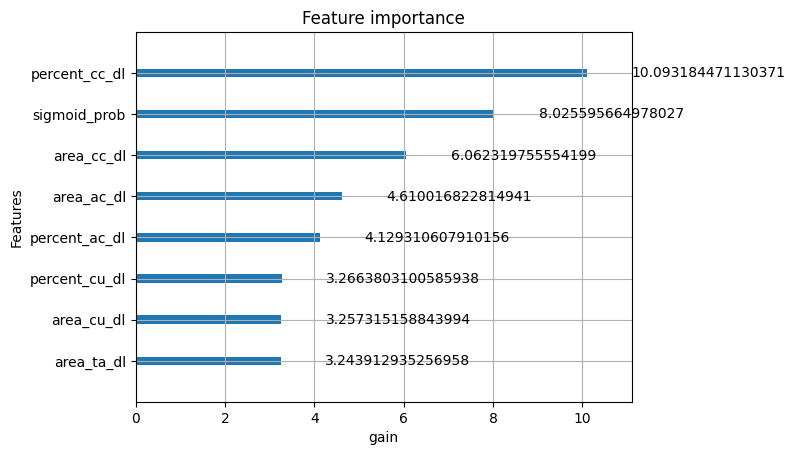

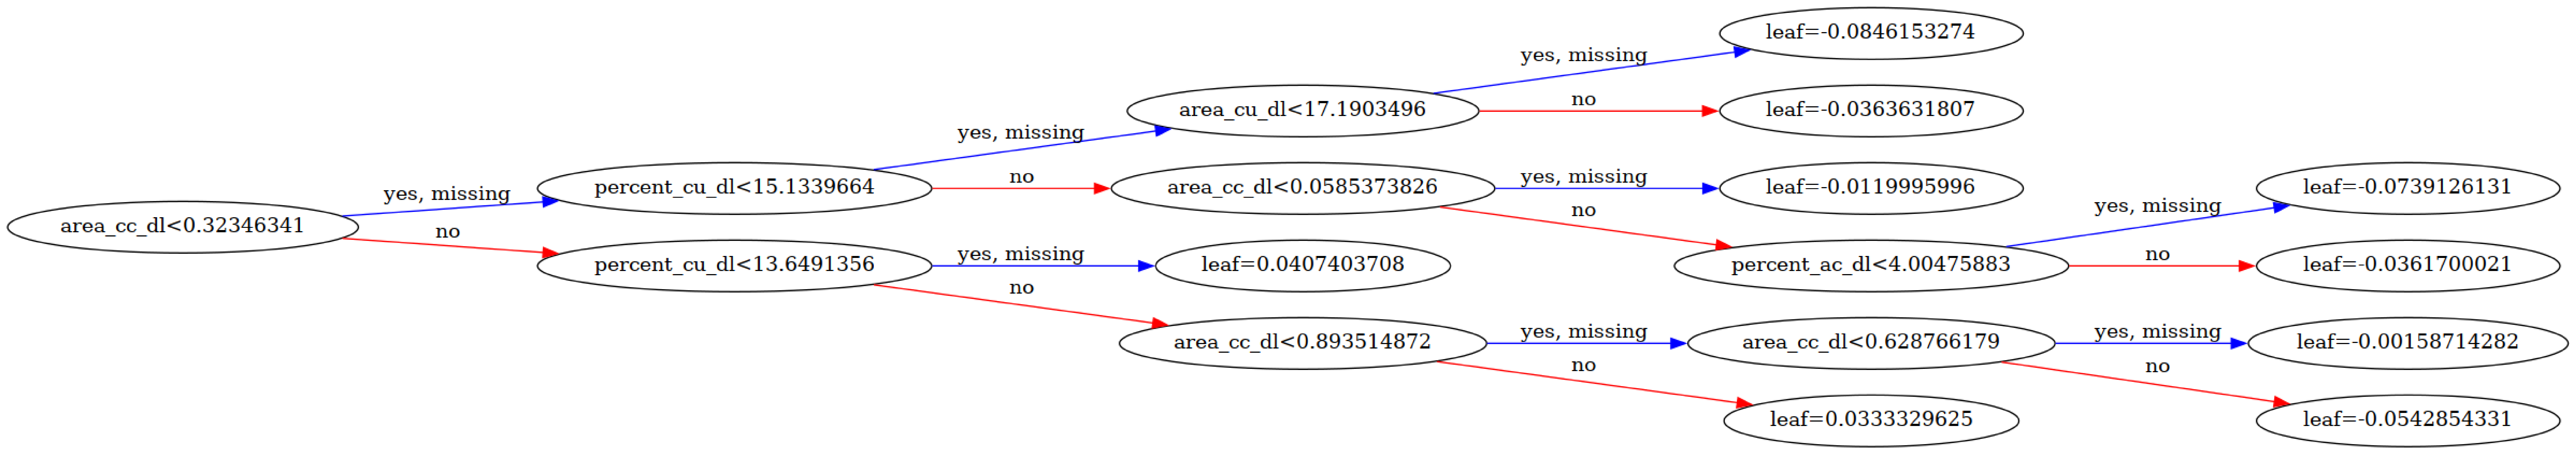

In [19]:
## total
X = df_cal[["file","GROUP",'percent_cu_dl','percent_ac_dl','percent_cc_dl','area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl','sigmoid_prob']]

y = df_cal[['GROUP']]

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=92)
Y_test, y_scores = run_xgboost_and_calculate_auc(X_train.drop("file",axis=1),target='GROUP',plot_all=False,ensembler=True, title="model/xgboost_all_vendor.json")

model_test = xgb.XGBClassifier()
model_test.load_model("model/xgboost_all_vendor.json")
xgb.plot_importance(model_test,max_num_features=20,importance_type='gain',xlabel='gain')
xgb.plot_tree(model_test, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


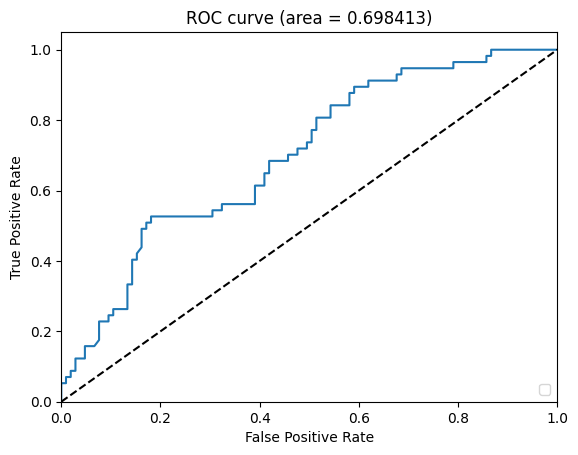

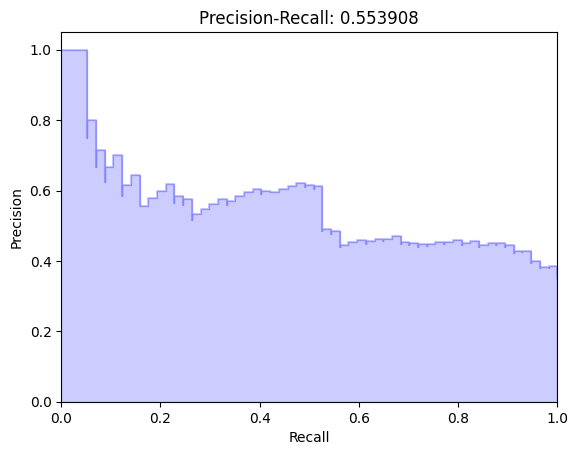


               precision    recall  f1-score   support

           0       0.71      0.87      0.78       105
           1       0.58      0.33      0.42        57

    accuracy                           0.68       162
   macro avg       0.64      0.60      0.60       162
weighted avg       0.66      0.68      0.65       162



In [20]:
y_pred = model_test.predict_proba(X_test.drop(["file","GROUP"], axis=1))
y_true = np.array(y_test)
y_scores = y_pred[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
average_precision = average_precision_score(y_test, y_scores)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall,precision,average_precision)
print('\n', classification_report(y_true, y_scores.round()))
#pd.DataFrame(zip(X_test['file'], y_test.GROUP.tolist(),y_scores),columns=['file','GROUP','scores']).to_csv("xgboost_density.csv",index=False)

In [21]:
y_pred = model_test.predict_proba(df_test[['percent_cu_dl','percent_ac_dl','percent_cc_dl','area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl','sigmoid_prob']])
y_scores = y_pred[:, 1]

In [22]:
name = 'csv/xgboost_all_vendor.csv'

with open(name, 'w') as result: 
    write = csv.writer(result)
    write.writerow(['file','scores'])

In [23]:
for i in range(len(df_test)):
    file = df_test.file.tolist()[i]
    score = y_scores[i]
    with open(name, 'a') as result: 
        write = csv.writer(result)
        write.writerow([file,score])

In [24]:
model_test_total = xgb.XGBClassifier()
model_test_total.load_model("model/xgboost_all_vendor.json")

In [25]:
df_test["scores_total"] = model_test_total.predict_proba(df_test[['percent_cu_dl','percent_ac_dl','percent_cc_dl','area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl','sigmoid_prob']])[:, 1]

/tmp/ipykernel_31521/2451753328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["scores_total"] = model_test_total.predict_proba(df_test[['percent_cu_dl','percent_ac_dl','percent_cc_dl','area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl','sigmoid_prob']])[:, 1]


In [26]:
df_test.to_csv("csv/test_all_vendor.csv")

In [27]:
df_test

,dataset,dataset_density,dataset_image,file_image,file,CENTER,ID,DATE,SIDE,SIDE_case,...,area_ta_dl,area_cu_dl,area_ac_dl,area_cc_dl,percent_ta_dl,percent_cu_dl,percent_ac_dl,percent_cc_dl,scores,scores_total
1,test,yes,yes,numpy/image_256x256/asan/10822454_RCC_20071228...,dicom/asan/10822454_RCC_20071228.dcm,asan,10822454,20071228.dcm,RCC,NaN,...,88.016064,21.818978,10.545612,0.864130,100.0,24.789768,11.981463,0.981787,0.561271,0.466874
3,test,yes,yes,numpy/image_256x256/asan/10956984_RCC_20090914...,dicom/asan/10956984_RCC_20090914.dcm,asan,10956984,20090914.dcm,RCC,LCC,...,55.425494,20.950406,8.879542,0.407848,100.0,37.799224,16.020682,0.735850,0.489607,0.481494
4,test,yes,yes,numpy/image_256x256/asan/10964062_LCC_20100401...,dicom/asan/10964062_LCC_20100401.dcm,asan,10964062,20100401.dcm,LCC,RCC,...,107.661410,39.690612,19.502849,1.138934,100.0,36.866146,18.114986,1.057885,0.352241,0.397408
5,test,yes,yes,numpy/image_256x256/asan/11013354_RCC_20070823...,dicom/asan/11013354_RCC_20070823.dcm,asan,11013354,20070823.dcm,RCC,NaN,...,104.541871,8.776184,1.238772,0.101400,100.0,8.394898,1.184953,0.096995,0.130490,0.123333
6,test,yes,yes,numpy/image_256x256/asan/11025566_LCC_20070917...,dicom/asan/11025566_LCC_20070917.dcm,asan,11025566,20070917.dcm,LCC,NaN,...,115.228297,29.098142,12.540858,0.710883,100.0,25.252601,10.883488,0.616934,0.281550,0.318612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,test,yes,no,numpy/image_256x256/ncc2020/25475_LCC_19000101...,dicom/ncc2020/25475_LCC_19000101.dcm,ncc2020,25475,19000101.dcm,LCC,NaN,...,118.838576,18.182237,3.325637,0.024171,100.0,15.299945,2.798449,0.020339,0.432674,0.413792
1606,test,yes,no,numpy/image_256x256/ncc2020/25539_RCC_19000101...,dicom/ncc2020/25539_RCC_19000101.dcm,ncc2020,25539,19000101.dcm,RCC,NaN,...,80.059079,16.910102,7.358554,0.297375,100.0,21.122029,9.191405,0.371445,0.229770,0.274680
1607,test,yes,no,numpy/image_256x256/ncc2020/25558_RCC_19000101...,dicom/ncc2020/25558_RCC_19000101.dcm,ncc2020,25558,19000101.dcm,RCC,NaN,...,81.827964,11.021948,4.349640,0.187854,100.0,13.469660,5.315591,0.229572,0.172449,0.201265
1611,test,yes,no,numpy/image_256x256/ncc2020/25643_LCC_19000101...,dicom/ncc2020/25643_LCC_19000101.dcm,ncc2020,25643,19000101.dcm,LCC,NaN,...,105.041881,7.461935,0.977675,0.059043,100.0,7.103771,0.930748,0.056209,0.147895,0.162841


## total_area + 3 area + sigmodie probability - model name : xgboost_ta_vendor.json

variables: 5, rows:646, flags:164


/home/jslee/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
38        0.898414       0.006173       0.784174       0.03313
Area under ROC: 0.760075


/home/jslee/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/jslee/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


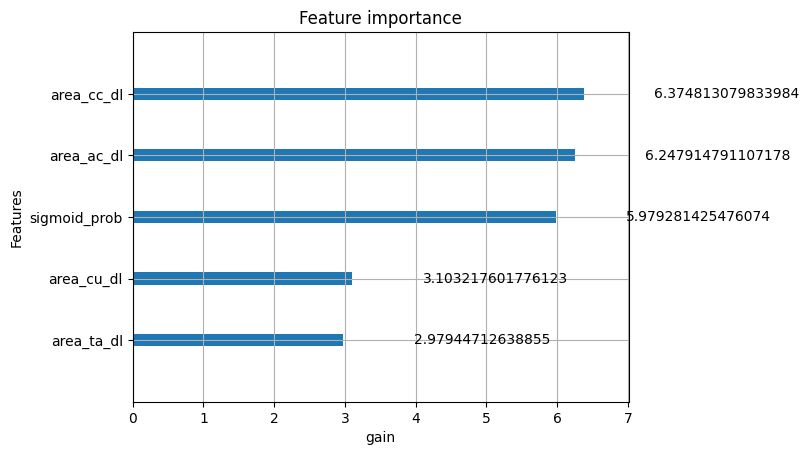

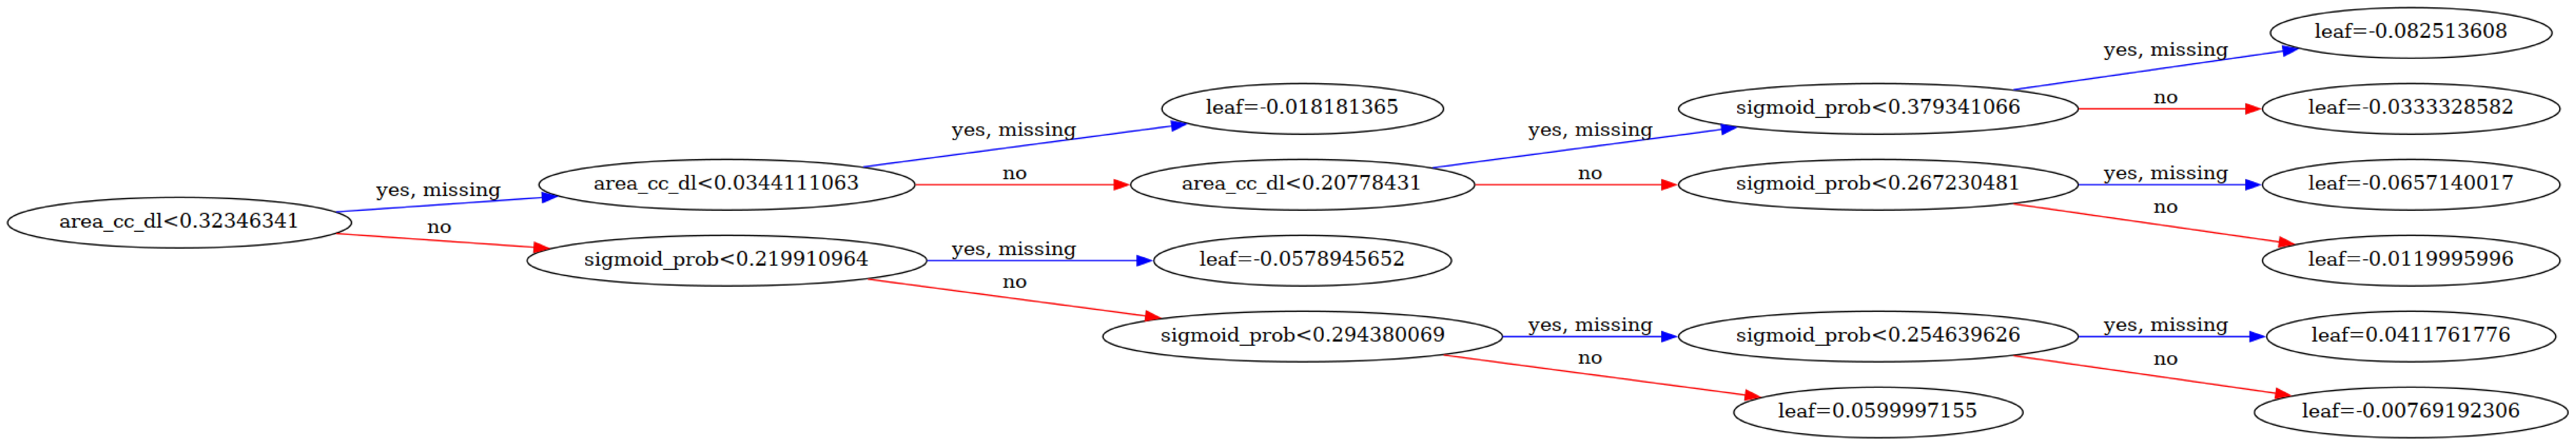

In [28]:
X = df_cal[["file","GROUP",'area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl','sigmoid_prob']]

y = df_cal[['GROUP']]

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=92)
Y_test, y_scores = run_xgboost_and_calculate_auc(X_train.drop("file",axis=1),target='GROUP',plot_all=False,ensembler=True, title="model/xgboost_ta_vendor.json")

model_test = xgb.XGBClassifier()
model_test.load_model("model/xgboost_ta_vendor.json")
xgb.plot_importance(model_test,max_num_features=20,importance_type='gain',xlabel='gain')
xgb.plot_tree(model_test, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


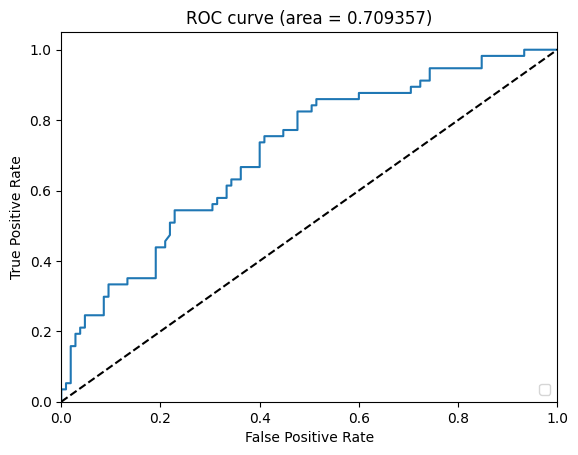

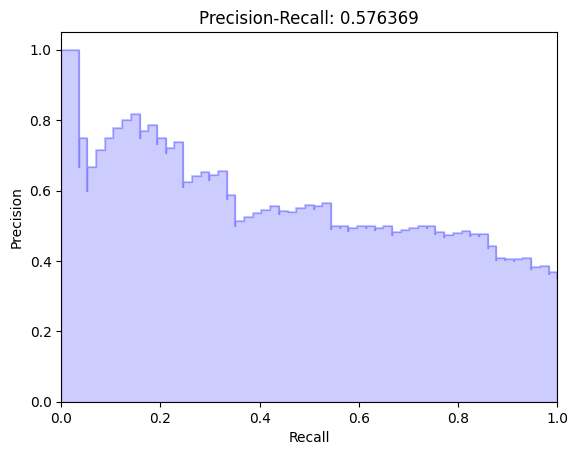


               precision    recall  f1-score   support

           0       0.71      0.90      0.80       105
           1       0.66      0.33      0.44        57

    accuracy                           0.70       162
   macro avg       0.68      0.62      0.62       162
weighted avg       0.69      0.70      0.67       162



In [29]:
y_pred = model_test.predict_proba(X_test.drop(["file","GROUP"], axis=1))
y_true = np.array(y_test)
y_scores = y_pred[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
average_precision = average_precision_score(y_test, y_scores)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall,precision,average_precision)
print('\n', classification_report(y_true, y_scores.round()))
#pd.DataFrame(zip(X_test['file'], y_test.GROUP.tolist(),y_scores),columns=['file','GROUP','scores']).to_csv("xgboost_density.csv",index=False)

In [30]:
y_pred = model_test.predict_proba(df_test[['area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl','sigmoid_prob']])
y_scores = y_pred[:, 1]

In [31]:
import csv

name = 'csv/xgboost_ta_area.csv'

with open(name, 'w') as result: 
    write = csv.writer(result)
    write.writerow(['file','scores'])

In [32]:
for i in range(len(df_test)):
    file = df_test.file.tolist()[i]
    score = y_scores[i]
    with open(name, 'a') as result: 
        write = csv.writer(result)
        write.writerow([file,score])

In [33]:
model_test_total = xgb.XGBClassifier()
model_test_total.load_model("model/xgboost_ta_vendor.json")

In [34]:
df_test["scores_total"] = model_test_total.predict_proba(df_test[['area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl','sigmoid_prob']])[:, 1]

/tmp/ipykernel_31521/1646129258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["scores_total"] = model_test_total.predict_proba(df_test[['area_ta_dl','area_cu_dl','area_ac_dl','area_cc_dl','sigmoid_prob']])[:, 1]


In [35]:
    df_test.to_csv("csv/test_ta_area.csv")

In [36]:
df_test

,dataset,dataset_density,dataset_image,file_image,file,CENTER,ID,DATE,SIDE,SIDE_case,...,area_ta_dl,area_cu_dl,area_ac_dl,area_cc_dl,percent_ta_dl,percent_cu_dl,percent_ac_dl,percent_cc_dl,scores,scores_total
1,test,yes,yes,numpy/image_256x256/asan/10822454_RCC_20071228...,dicom/asan/10822454_RCC_20071228.dcm,asan,10822454,20071228.dcm,RCC,NaN,...,88.016064,21.818978,10.545612,0.864130,100.0,24.789768,11.981463,0.981787,0.561271,0.561271
3,test,yes,yes,numpy/image_256x256/asan/10956984_RCC_20090914...,dicom/asan/10956984_RCC_20090914.dcm,asan,10956984,20090914.dcm,RCC,LCC,...,55.425494,20.950406,8.879542,0.407848,100.0,37.799224,16.020682,0.735850,0.489607,0.489607
4,test,yes,yes,numpy/image_256x256/asan/10964062_LCC_20100401...,dicom/asan/10964062_LCC_20100401.dcm,asan,10964062,20100401.dcm,LCC,RCC,...,107.661410,39.690612,19.502849,1.138934,100.0,36.866146,18.114986,1.057885,0.352241,0.352241
5,test,yes,yes,numpy/image_256x256/asan/11013354_RCC_20070823...,dicom/asan/11013354_RCC_20070823.dcm,asan,11013354,20070823.dcm,RCC,NaN,...,104.541871,8.776184,1.238772,0.101400,100.0,8.394898,1.184953,0.096995,0.130490,0.130490
6,test,yes,yes,numpy/image_256x256/asan/11025566_LCC_20070917...,dicom/asan/11025566_LCC_20070917.dcm,asan,11025566,20070917.dcm,LCC,NaN,...,115.228297,29.098142,12.540858,0.710883,100.0,25.252601,10.883488,0.616934,0.281550,0.281550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,test,yes,no,numpy/image_256x256/ncc2020/25475_LCC_19000101...,dicom/ncc2020/25475_LCC_19000101.dcm,ncc2020,25475,19000101.dcm,LCC,NaN,...,118.838576,18.182237,3.325637,0.024171,100.0,15.299945,2.798449,0.020339,0.432674,0.432674
1606,test,yes,no,numpy/image_256x256/ncc2020/25539_RCC_19000101...,dicom/ncc2020/25539_RCC_19000101.dcm,ncc2020,25539,19000101.dcm,RCC,NaN,...,80.059079,16.910102,7.358554,0.297375,100.0,21.122029,9.191405,0.371445,0.229770,0.229770
1607,test,yes,no,numpy/image_256x256/ncc2020/25558_RCC_19000101...,dicom/ncc2020/25558_RCC_19000101.dcm,ncc2020,25558,19000101.dcm,RCC,NaN,...,81.827964,11.021948,4.349640,0.187854,100.0,13.469660,5.315591,0.229572,0.172449,0.172449
1611,test,yes,no,numpy/image_256x256/ncc2020/25643_LCC_19000101...,dicom/ncc2020/25643_LCC_19000101.dcm,ncc2020,25643,19000101.dcm,LCC,NaN,...,105.041881,7.461935,0.977675,0.059043,100.0,7.103771,0.930748,0.056209,0.147895,0.147895
